<a href="https://colab.research.google.com/github/OgnjenJovanovicc/Leaf-Classification-Project-Ognejn_Jovanovic_IT7-2021/blob/main/Projekat_Jovanovic_Ognjen_IT7_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uvod
U ovom projektu fokus je na klasifikaciji vrsta lišća na osnovu numeričkih karakteristika prikupljenih u datasetu. Cilj je razviti model koji može precizno prepoznati i razlikovati različite vrste biljaka na osnovu merenih atributa. S obzirom na kompleksnost i brojnost klasa (99 različitih vrsta), neophodno je koristiti efikasan pristup mašinskom učenju koji može da se nosi sa velikim brojem ulaznih parametara i višeklasnim problemom klasifikacije.

Razrada
Za rešavanje ovog problema izabrana je neuronska mreža duboke arhitekture jer je poznato da su duboki modeli sposobni da nauče kompleksne obrasce i nelinearne odnose u podacima. U projektu je korišćen Keras API u okviru TensorFlow biblioteke, koji omogućava fleksibilnu i efikasnu izgradnju i treniranje neuronskih mreža.

Pre početka treniranja, podaci su prethodno obrađeni: kategorijske oznake su pretvorene u one-hot vektor format, a numeričke karakteristike su normalizovane kako bi se ubrzao i stabilizovao proces treniranja. Dataset je podeljen na trening i validacioni skup radi bolje generalizacije modela.

Za optimizaciju hiperparametara korišćen je Keras Tuner, koji je omogućio automatsko pronalaženje najboljeg broja slojeva, jedinica u slojevima i stopa drop-out regularizacije, čime se smanjuje mogućnost prenaučenosti i poboljšava performansa modela. Tokom treniranja su korišćene tehnike za prevenciju prenaučenosti kao što su EarlyStopping, smanjenje stope učenja (ReduceLROnPlateau) i čuvanje najboljeg modela (ModelCheckpoint).

Evaluacija modela je izvršena kroz metrike tačnosti (accuracy), klasifikacioni izveštaj (precision, recall, f1-score) i vizuelnu analizu konfuzione matrice, što je omogućilo detaljno sagledavanje uspešnosti modela po svakoj klasi.

Zaključak
Izbor neuronske mreže duboke arhitekture i upotreba automatske optimizacije hiperparametara pokazali su se kao efikasan pristup za složen problem klasifikacije lišća sa velikim brojem klasa. Korišćenjem tehnika normalizacije, regularizacije i pažljive kontrole procesa treniranja uspeli smo da postignemo zadovoljavajuću tačnost i pouzdanost modela. Ovaj pristup može biti primenjen i na slične probleme u biometriji i identifikaciji na osnovu složenih karakteristika. U budućnosti, moguće je dodatno unaprediti performanse modela korišćenjem složenijih arhitektura ili dodatnih izvora podataka.

In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
import zipfile as zp
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

U ovom početnom delu projekta se učitavaju potrebne biblioteke i moduli za rad. matplotlib i seaborn se koriste za vizualizaciju podataka i rezultata, dok pandas i numpy služe za efikasno upravljanje i analizu podataka. zipfile omogućava rad sa ZIP arhivama, dok os pomaže u upravljanju fajlovima i direktorijumima. Iz sklearn biblioteke se importuju alati za predprocesiranje podataka kao što su OneHotEncoder (pretvaranje kategorijskih podataka u binarni format) i MinMaxScaler (normalizacija numeričkih vrednosti), zatim funkcija za podelu podataka na trening i validacioni skup (train_test_split) i metričke funkcije za evaluaciju modela kao što su klasifikacioni izveštaj i konfuzioni matriks. Iz tensorflow.keras se uvoze moduli za izgradnju neuronskih mreža (model, slojevi i regularizacija) i kontrolu procesa treniranja kroz callback funkcije (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint). Ovaj skup biblioteka i modula predstavlja osnovu za razvoj, treniranje i evaluaciju modela dubokog učenja u projektu klasifikacije lišća.

In [2]:
def unzip(location, destination):
    with zp.ZipFile(location, 'r') as file_zip:
        file_zip.extractall(destination)

Ova funkcija služi za raspakivanje ZIP arhive. Prima dva argumenta: location koji označava putanju do ZIP fajla, i destination gde će sadržaj arhive biti raspakovan. Unutar funkcije se otvara ZIP fajl u režimu za čitanje, a zatim se pomoću extractall svi fajlovi iz arhive izdvajaju u zadatu destinaciju. Na ovaj način omogućavamo jednostavno i brzo raspakivanje podataka potrebnih za dalju analizu ili treniranje modela.

In [3]:
def remove_labels(df, label):
    x = df.drop(label, axis=1)
    y = df[label]
    return x, y

Ova funkcija prima DataFrame df i ime kolone label koju želimo da izdvojimo kao ciljnu promenljivu. Funkcija prvo uklanja kolonu sa etiketama iz originalnog DataFrame-a i smešta preostale kolone u promenljivu x, koja predstavlja ulazne karakteristike (features). Zatim izdvajamo samo kolonu sa etiketama u promenljivu y, koja predstavlja ciljnu promenljivu ili target. Na kraju, funkcija vraća tuple (x, y), što olakšava dalju obradu podataka tako što jasno odvaja ulazne podatke od izlaznih.

In [4]:
from google.colab import files
uploaded = files.upload()

unzip("Leaf_Classification.zip", "PPPO")
print(os.listdir("PPPO"))

plt.style.use('dark_background')

Saving Leaf_Classification.zip to Leaf_Classification.zip
['test.csv.zip', 'sample_submission.csv.zip', 'images.zip', 'train.csv.zip']


Ovaj deo koda omogućava učitavanje podataka i osnovnu pripremu za rad u Google Colab okruženju. Najpre se uvozi modul files iz biblioteke google.colab, koji omogućava da se fajlovi sa lokalnog računara otpreme u Colab, a komanda files.upload() otvara dijalog za izbor i upload fajla, u ovom slučaju ZIP arhive sa podacima. Zatim se poziva ranije definisana funkcija unzip() koja raspakuje fajl Leaf_Classification.zip u direktorijum PPPO, nakon čega se pomoću os.listdir() ispisuje sadržaj tog direktorijuma kako bi se proverilo da li su podaci uspešno otpakovani. Na kraju, plt.style.use('dark_background') postavlja tamnu temu za sve naredne grafikone, čineći ih vizuelno uočljivijim i estetski privlačnijim.

In [5]:
train_data = pd.read_csv("PPPO/train.csv.zip", index_col=0)
for i in train_data.columns:
    if train_data[i].isna().any():
        print(f"{i} has null values")

Dataset za treniranje se učitava pomoću pd.read_csv(), gde se fajl train.csv.zip iz direktorijuma PPPO otvara kao Pandas DataFrame, pri čemu je prvi stupac postavljen kao indeks (index_col=0) kako bi se očuvao identifikator svakog uzorka. Nakon učitavanja, prolazi se kroz sve kolone DataFrame-a i proverava da li neka od njih sadrži nedostajuće vrednosti (NaN) pomoću uslova train_data[i].isna().any(). Ako se pronađu nedostajuće vrednosti, za svaku takvu kolonu ispisuje se poruka u formatu "{i} has null values", što omogućava brzu dijagnostiku i otkrivanje potencijalnih problema u kvalitetu podataka pre nego što se krene sa daljom obradom i treniranjem modela.

In [6]:
species = train_data[['species']]
oh = OneHotEncoder()
species_oh = oh.fit_transform(species).toarray()
species_df = pd.DataFrame(species_oh, index=train_data.index, columns=oh.categories_[0])


Iz skupa za treniranje izdvaja se samo kolona species, koja predstavlja oznake klasa (vrste biljaka), i smešta se u novi DataFrame kako bi se pripremila za kodiranje. Zatim se koristi OneHotEncoder() iz biblioteke scikit-learn, koji svaku kategoriju pretvara u binarni vektor (one-hot reprezentaciju), gde svaka vrsta dobija jedinstvenu kombinaciju nula i jedinica. Metoda fit_transform() istovremeno uči sve moguće kategorije i transformiše podatke, a toarray() rezultat pretvara u NumPy niz radi lakšeg rukovanja. Na kraju se dobija novi DataFrame species_df, koji sadrži ove binarne reprezentacije sa istim indeksima kao originalni skup podataka i imenima kolona preuzetim iz oh.categories_[0], čime su oznake klasa spremne za upotrebu u neuronskoj mreži.

In [7]:
features = train_data.drop('species', axis=1)
min_max = MinMaxScaler()
features_norm = pd.DataFrame(min_max.fit_transform(features), index=features.index, columns=features.columns)


Iz originalnog skupa podataka uklanja se kolona species kako bi se izdvojile samo karakteristike (feature-i) koje služe kao ulaz modelu. Zatim se koristi MinMaxScaler iz biblioteke scikit-learn za normalizaciju ovih karakteristika, pri čemu se vrednosti svake kolone skaliraju tako da budu unutar intervala od 0 do 1. Metoda fit_transform() prilagođava skalu na osnovu podataka i istovremeno transformiše vrednosti, a rezultat se smešta u novi DataFrame features_norm, koji zadržava iste indekse i nazive kolona kao originalni skup. Normalizacija je važna jer omogućava da sve ulazne karakteristike imaju istu skalu, čime se olakšava i ubrzava treniranje neuronske mreže.



In [8]:
train_data_full = pd.concat([features, species_df], axis=1)
train_data_norm = pd.concat([features_norm, species_df], axis=1)

Nakon što su pripremljene originalne i normalizovane karakteristike (features i features_norm), one se kombinuju sa one-hot enkodiranim oznakama klasa (species_df) koristeći pd.concat() duž kolona (axis=1). Tako nastaju dva kompletna skupa podataka: train_data_full, koji sadrži originalne karakteristike zajedno sa oznakama, i train_data_norm, koji sadrži normalizovane karakteristike sa istim oznakama. Ova dva skupa omogućavaju poređenje rada modela na normalizovanim i nenormalizovanim podacima, kao i jednostavniju dalju podelu na trening i validacione skupove.

In [9]:
train_set, val_set = train_test_split(
    train_data_full, test_size=0.3, random_state=42, stratify=species
)
train_set_norm, val_set_norm = train_test_split(
    train_data_norm, test_size=0.3, random_state=42, stratify=species
)

Podaci se dele na trening i validacione skupove pomoću funkcije train_test_split iz biblioteke scikit-learn, pri čemu se za validacioni skup izdvaja 30% podataka, a preostali deo ide u trening skup. Koristi se parametar random_state=42 kako bi podela bila reproducibilna, a stratify=species osigurava da proporcije različitih klasa (vrsta biljaka) budu iste u oba skupa, što pomaže u balansiranju podataka i sprečava pristrasnost modela prema dominantnim klasama. Ovaj proces se primenjuje i na originalni skup sa nenormalizovanim podacima (train_data_full), kao i na skup sa normalizovanim podacima (train_data_norm), čime se dobijaju četiri odvojena skupa: trening i validacija za oba tipa podataka.

In [10]:
x_train, y_train = remove_labels(train_set, oh.categories_[0])
x_train_norm, y_train_norm = remove_labels(train_set_norm, oh.categories_[0])
x_val, y_val = remove_labels(val_set, oh.categories_[0])
x_val_norm, y_val_norm = remove_labels(val_set_norm, oh.categories_[0])


Iz prethodno podeljenih trening i validacionih skupova izdvajaju se ulazni podaci (feature-i) i ciljne vrednosti (oznake klasa) korišćenjem definisane funkcije remove_labels. Ova funkcija uklanja kolone koje predstavljaju klase (oh.categories_[0]) iz skupa podataka i vraća dva dela: x_train i x_train_norm sadrže samo numeričke karakteristike za treniranje, odnosno normalizovane karakteristike, dok y_train i y_train_norm sadrže odgovarajuće oznake klasa u one-hot formatu. Isto važi i za validacione skupove (x_val, y_val i x_val_norm, y_val_norm). Na ovaj način se pripremaju ulazni i izlazni podaci u formatu koji je potreban za treniranje neuronske mreže.

In [11]:
!pip install keras-tuner
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input((x_train_norm.shape[1],)))


    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.6, step=0.1)))
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(99, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='leaf_classification'
)

tuner.search(x_train_norm, y_train_norm, epochs=50, validation_data=(x_val_norm, y_val_norm))
best_model = tuner.get_best_models(1)[0]


Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.9764309525489807

Best val_accuracy So Far: 0.996632993221283
Total elapsed time: 00h 03m 15s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


U ovom delu koda instalira se i uvozi biblioteka keras-tuner, koja služi za automatsku optimizaciju hiperparametara neuronskih mreža. Definiše se funkcija build_model koja pravi model u vidu sekvencijalne mreže sa ulaznim slojem prilagođenim broju karakteristika (x_train_norm.shape[1]). Broj skrivenih slojeva, broj neurona u svakom sloju, kao i stopa dropout-a, biraju se dinamički kroz hiperparametre koje keras-tuner istražuje, pri čemu se broj slojeva kreće od 1 do 3, a broj neurona po sloju od 64 do 512 sa korakom od 64. Svaki sloj sadrži ReLU aktivaciju, dropout sloj za regularizaciju i batch normalizaciju za stabilizaciju treniranja. Na kraju, izlazni sloj ima 99 neurona sa softmax aktivacijom, jer je zadatak klasifikacija na 99 klasa, a model se kompajlira koristeći optimizator Adam i kategorijsku unakrsnu entropiju kao funkciju greške, dok se prati tačnost. Zatim se kreira RandomSearch tuner koji nasumično pretražuje kombinacije hiperparametara u najviše 10 pokušaja, ocenjujući modele prema validacionoj tačnosti. Pokreće se pretraga hiperparametara na trening i validacionim podacima tokom 50 epoha, a na kraju se bira najbolji model prema rezultatima pretrage.

In [12]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=7),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

U ovom delu definišu se callback funkcije koje će pratiti i upravljati procesom treniranja modela. EarlyStopping prekida treniranje ako se validaciona tačnost ne poboljša tokom 15 uzastopnih epoha, pri čemu se vraćaju težine modela sa najboljim rezultatima kako bi se izbeglo pretreniravanje. ReduceLROnPlateau automatski smanjuje brzinu učenja (learning rate) za faktor 0.3 ako validaciona tačnost ne napreduje u roku od 7 epoha, što pomaže modelu da se bolje prilagodi i izbegne zaglavljivanje u lokalnim minimumima. ModelCheckpoint čuva trenutno najbolji model tokom treniranja u fajl best_model.h5, omogućavajući naknadno učitavanje najefikasnijeg modela bez potrebe za ponovnim treniranjem. Ove callback funkcije zajedno čine proces treniranja efikasnijim i stabilnijim.

In [13]:
history = best_model.fit(
    x_train_norm, y_train_norm,
    epochs=200,
    batch_size=32,
    validation_data=(x_val_norm, y_val_norm),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9730 - loss: 0.1515

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9732 - loss: 0.1515 - val_accuracy: 0.9832 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9785 - loss: 0.1407 - val_accuracy: 0.9798 - val_loss: 0.0989 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9596 - loss: 0.1566 - val_accuracy: 0.9798 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9697 - loss: 0.1500 - val_accuracy: 0.9697 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9586 - loss: 0.1819 - val_accuracy: 0.9798 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 6/200
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9682 - loss: 0.1577

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9687 - loss: 0.1577 - val_accuracy: 0.9764 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 7/200
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9565 - loss: 0.1725

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9577 - loss: 0.1701 - val_accuracy: 0.9764 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9715 - loss: 0.1412 - val_accuracy: 0.9798 - val_loss: 0.0868 - learning_rate: 0.0010
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9696 - loss: 0.1462 - val_accuracy: 0.9832 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9767 - loss: 0.1219 - val_accuracy: 0.9764 - val_loss: 0.1126 - learning_rate: 0.0010
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9612 - loss: 0.1599 - val_accuracy: 0.9832 - val_loss: 0.0938 - learning_rate: 0.0010
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9506 - loss: 0.1759 - val_accuracy: 0.9764 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9658 - loss: 0.1535 - val_accu

Koristeći najbolje parametre pronađene tunerom, model se trenira na normalizovanim trening podacima (x_train_norm, y_train_norm) do maksimalno 200 epoha sa batch veličinom od 32 uzorka po iteraciji. Tokom treniranja, za validaciju se koriste podaci iz validacionog skupa (x_val_norm, y_val_norm) kako bi se pratio napredak modela i sprečilo pretreniravanje. Definisani callback-ovi prate proces i automatski prekidaju treniranje u slučaju stagnacije, smanjuju brzinu učenja i čuvaju najbolji model. Parametar verbose=1 omogućava ispis detaljnih informacija o toku treniranja. Sve informacije o preciznosti i greškama u toku epoha se čuvaju u promenljivoj history, što omogućava kasniju analizu performansi modela kroz grafikone.

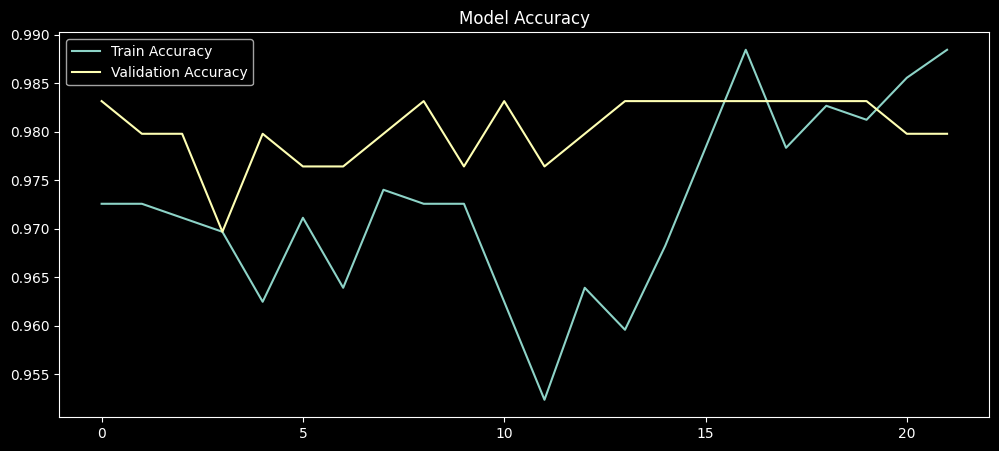

In [14]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

Ovaj deo koda prikazuje grafikon koji ilustruje promenu tačnosti modela tokom treninga. Prvo se definiše veličina figure radi bolje preglednosti, zatim se crtaju dve linije: jedna predstavlja tačnost na trening skupu (history.history['accuracy']), a druga tačnost na validacionom skupu (history.history['val_accuracy']). Legenda jasno označava obe linije, dok naslov grafika „Model Accuracy“ daje kontekst. Ovaj grafikon pomaže u vizuelnoj proceni kako model uči kroz epohe, da li se tačnost poboljšava i postoji li potencijalno pretreniravanje ili podtreniravanje.

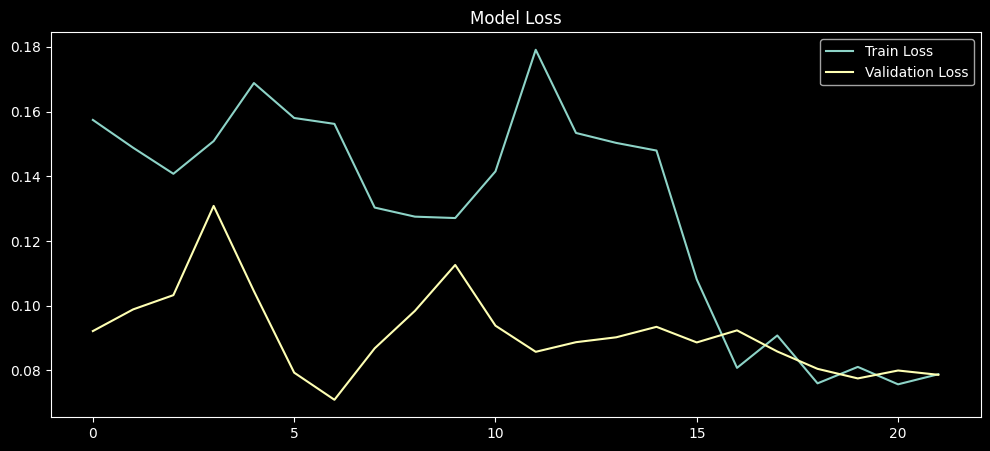

In [15]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

Ovaj deo koda prikazuje grafikon koji prati promenu vrednosti funkcije greške (loss) tokom treninga modela. Veličina figure je podešena za jasnu vizualizaciju, a prikazane su dve linije: jedna za grešku na trening skupu (history.history['loss']), i druga za grešku na validacionom skupu (history.history['val_loss']). Legenda označava obe linije, a naslov „Model Loss“ ukazuje na sadržaj grafikona. Ova vizualizacija omogućava praćenje kako se model prilagođava podacima kroz epohe i pomaže u identifikaciji problema poput pretreniravanja ili neuspešnog učenja ukoliko gubitak ne opada kako treba.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16    

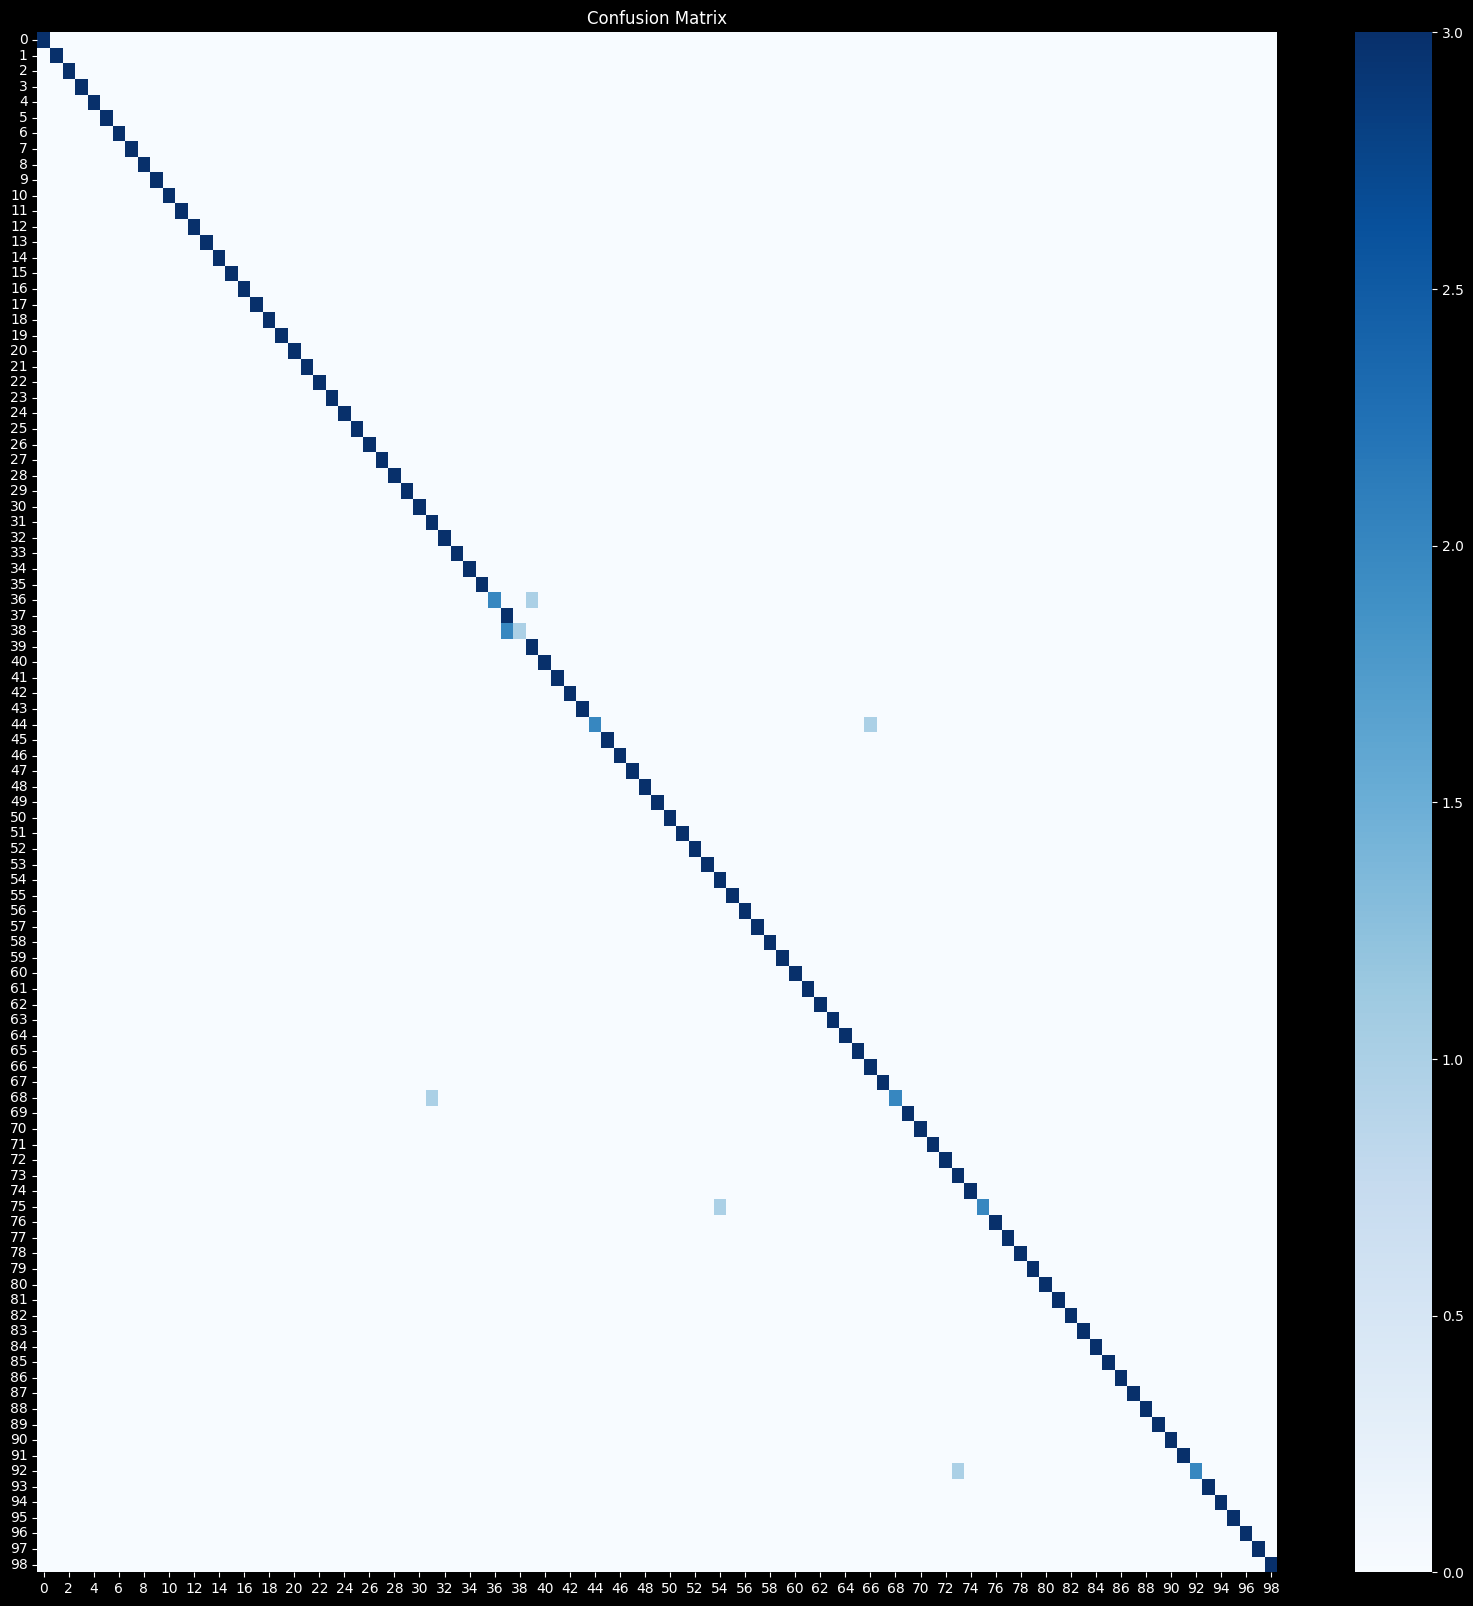

In [16]:
y_val_pred = best_model.predict(x_val_norm)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val_norm.values, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_val_true, y_val_pred_classes))

cm = confusion_matrix(y_val_true, y_val_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

U ovom delu koda se vrši evaluacija treniranog modela na validacionom skupu. Prvo se pomoću best_model.predict dobijaju verovatnoće pripadnosti svakoj od klasa za svaki uzorak u validacionom skupu, a zatim se koriste funkcije np.argmax da se pretvore te verovatnoće u konkretne klase — i za predviđene vrednosti (y_val_pred_classes), ali i za stvarne ciljne vrednosti (y_val_true). Nakon toga, ispisuje se izveštaj o klasifikaciji (classification_report), koji daje detaljne informacije o preciznosti, odzivu i F1 skorovima za svaku klasu, omogućavajući analizu performansi modela. Takođe, generiše se i konfuziiona matrica (confusion_matrix) koja vizuelno prikazuje koliko je tačno ili pogrešno klasifikovan svaki od uzoraka. Za bolju preglednost matrica se prikazuje kao toplinska mapa (heatmap) u velikoj figuri, sa plavim tonovima koji naglašavaju jačinu tačnih i netačnih klasifikacija. Ova kombinacija kvantitativnih i vizuelnih metrika pomaže u detaljnoj proceni uspešnosti modela i identifikaciji klasa koje model slabije prepoznaje.

Za procenu performansi modela korišćene su sledeće metrike:

Accuracy (tačnost) – pokazuje procenat ispravno klasifikovanih primera u odnosu na sve primere.

Precision (preciznost) – od svih primera koje je model označio kao određenu klasu, govori koliko ih je zaista tačno klasifikovano.

Recall (odziv) – od svih primera koji pripadaju određenoj klasi, pokazuje koliko ih je model uspešno prepoznao.

F1-score – kombinacija preciznosti i odziva; koristan pokazatelj kada je važno balansirati između ova dva kriterijuma.

Confusion matrix (matrica konfuzije) – vizuelni prikaz koji pokazuje kako model klasifikuje primere svake klase i koje klase se najčešće mešaju.

Balansiranje podataka:
Dodatno balansiranje podataka nije primenjeno jer je dataset relativno ravnomerno raspoređen (svaka od 99 klasa ima približno jednak broj uzoraka).



In [17]:
test_data = pd.read_csv('PPPO/test.csv.zip', index_col=0)
for i in test_data.columns:
    if test_data[i].isna().any():
        print(f"{i} has null values")

test_data_norm = pd.DataFrame(min_max.transform(test_data), index=test_data.index, columns=test_data.columns)
y_pred = best_model.predict(test_data_norm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


U ovom delu koda se učitavaju test podaci iz kompresovanog CSV fajla, pri čemu se indeks kolona koristi kao redni broj uzoraka. Proverava se da li postoje nedostajući podaci (null vrednosti) u bilo kojoj od kolona, što je važno jer nedostajuće vrednosti mogu negativno uticati na performanse modela. Zatim se primenjuje ista normalizacija (min_max.transform) kao i na trening skup, kako bi test podaci bili u istom opsegu vrednosti koje model očekuje. Na kraju, trenirani model predviđa verovatnoće pripadnosti svakoj klasi za svaki uzorak iz test skupa, čime se dobijaju rezultati potrebni za kreiranje konačnih predikcija.



In [18]:
submission = pd.DataFrame(y_pred, index=test_data_norm.index, columns=oh.categories_[0])
submission.to_csv('submission.csv')
print("Submission fajl sacuvan.")

Submission fajl sacuvan.


Na osnovu predikcija modela (y_pred), kreira se DataFrame gde su redovi indeksirani prema uzorcima test podataka, a kolone predstavljaju sve moguće klase (99 u ovom slučaju) sa imenima klasa iz originalnog one-hot enkodera. Ovaj DataFrame predstavlja verovatnoće da svaki test primer pripada određenoj klasi. Na kraju, rezultati se čuvaju u CSV fajl nazvan submission.csv, što omogućava dalje korišćenje predikcija, na primer za slanje na takmičenje ili evaluaciju. Poruka potvrđuje uspešno čuvanje fajla.



In [19]:
num_classes = train_data['species'].nunique()
print(f"Broj klasa u datasetu je: {num_classes}")

Broj klasa u datasetu je: 99
